In [1]:
import os
import json
import pandas as pd
import collections

annotations_intermediate_path = '/data/annotations/'
annotations_ending_path = {'train':'train.json', 'val':'val.json'}
images_intermediate_path = {'train':'/data/images/train/', 'val':'/data/images/val/'}

# Creating a function to prepare the training and validation data.

def prepare (dataset, create = False):
# Dataset is either training or validation.
# The create option will dictate if .json file is created. These files have already been created so we set
# create equal to a default value of False.
    with open(os.path.abspath('.') + annotations_intermediate_path + annotations_ending_path[dataset], 'r') as f:
        data = json.load(f)
    directory = os.path.abspath('.') + annotations_intermediate_path + annotations_ending_path[dataset]

# The 2 data frames of interest.
    images_df = pd.DataFrame(data['images'])
    annotations_df = pd.DataFrame(data['annotations'])

# Images are indexed by image_id (number of unique values for image_id coincides with the number of training images).
# Captions are indexed by id (number of unique values for id coincides with the number of training captions).

# If is_precanned is True, then the associated caption is: 'Quality issues are too severe to recognize visual content.'
# If is_rejected is True, then the associated caption is spam. See peeking_into_train.ipynb for examples.
# If text_detected is True, then the image contains text.

# A richer analysis would involve an examination of text_detected. We do not pursue this.

# Preparing the images data frame for a join.
    images_df.drop(['vizwiz_url', 'text_detected'], axis = 1, inplace = True)

# This is added in order to account for how the data sets are enumerated. This applies to val, not to train.
    images_df['id'] = images_df['id']-images_df['id'][0] 
    images_df.columns = ['file_name', 'image_id']

# Preparing the annotations data frame for a join.
    annotations_df.drop(['text_detected'], axis =1,inplace=True )

# This is added in order to account for how the data sets are enumerated. This applies to val, not to train.
    annotations_df['image_id'] = annotations_df['image_id'] - annotations_df['image_id'][0]
    annotations_df['id'] = annotations_df['id']- annotations_df['id'][0]
    annotations_df.columns = ['caption', 'image_id', 'is_precanned', 'is_rejected', 'caption_id']

# We now join the data frames.
    joined_df = annotations_df.join(images_df, on = 'image_id', how = 'left', lsuffix='', rsuffix = '_img')
    joined_df.drop(['image_id_img'], axis = 1, inplace = True)

# From this newly formed dataframe, we construct several dataframes in order to shed light on the relationship between
# images, captions, is_precanned, and is_rejected.

# 1. The number of images having n precanned captions, where n ranges from 0 to 5.
    df1 = annotations_df.groupby('image_id').agg({'is_precanned':'sum'}).value_counts(sort=False).to_frame()
    df1.columns = ['number_of_images']
    df1['number_of_precanned_captions'] = [n for n in range(list(df1.index)[0][0],list(df1.index)[-1][0]+1)]
    df1 = df1.rename_axis('Index')
    print(df1)

    df1_columns = list(df1.columns)
    df1.plot.bar(x= df1_columns[1], xlabel = df1_columns[1], y = df1_columns[0], ylabel = df1_columns[0],
    rot=0, legend = None, title = 'Number of images with n precanned captions')

# 2. The number of captions that are precanned.
    df2 = annotations_df.groupby('caption_id').agg({'is_precanned':'sum'}).value_counts(sort=False).to_frame()
    df2.columns = ['number_of_captions']
    df2['is_precanned'] = [n for n in range(list(df2.index)[0][0],list(df2.index)[-1][0]+1)]
    df2 = df2.rename_axis('Index')
    print(df2)

    df2_columns = list(df2.columns)
    df2.plot.bar(x= df2_columns[1], xlabel = df2_columns[1], y = df2_columns[0], ylabel = df2_columns[0],
    rot=0, legend = None, title = 'Number of precanned captions')

# 3. The number of images having n rejected captions, where n ranges from 0 to 5.
    df3 = annotations_df.groupby('image_id').agg({'is_rejected':'sum'}).value_counts(sort=False).to_frame()
    df3.columns = ['number_of_images']
    df3['number_of_rejected_captions'] = [n for n in range(list(df3.index)[0][0],list(df3.index)[-1][0]+1)]
    df3 = df3.rename_axis('Index')
    print(df3)

    df3_columns = list(df3.columns)
    df3.plot.bar(x= df3_columns[1], xlabel = df3_columns[1], y = df3_columns[0], ylabel = df3_columns[0],
    rot=0, legend = None, title = 'Number of images with n rejected captions')

# 4. The number of captions that are rejected.
    df4 = annotations_df.groupby('caption_id').agg({'is_rejected':'sum'}).value_counts(sort=False).to_frame()
    df4.columns = ['number_of_captions']
    df4['is_rejected'] = [n for n in range(list(df4.index)[0][0],list(df4.index)[-1][0]+1)]
    df4 = df4.rename_axis('Index')
    print(df4)

    df4_columns = list(df4.columns)
    df4.plot.bar(x= df4_columns[1], xlabel = df4_columns[1], y = df4_columns[0], ylabel = df4_columns[0],
    rot=0, legend = None, title = 'Number of rejected captions')

# Before we tackle data frames 5 and 6, we need to form a new dataframe.
    pre_df56 = annotations_df[(annotations_df.is_rejected == True) & (annotations_df.is_precanned == True)]

# 5. The number of images that have n precanned and rejected captions.
    df5 = pre_df56.groupby('image_id').agg({'is_precanned':'sum'}).value_counts(sort=False).to_frame()
    df5.columns = ['number_of_images']
    df5['is_rejected_and_precanned'] = [n for n in range(list(df5.index)[0][0],list(df5.index)[-1][0]+1)]
    df5 =df5.rename_axis('Index')
    print(df5)

    df5_columns = list(df5.columns)
    df5.plot.bar(x= df5_columns[1], xlabel = df5_columns[1], y = df5_columns[0], ylabel = df5_columns[0],
    rot=0, legend = None, title = 'Number of images with n rejected and precanned captions')

# 6. The number of captions that are precanned and rejected.
    df6 = pre_df56.groupby('caption_id').agg({'is_precanned':'sum'}).value_counts(sort=False).to_frame()
    df6.columns = ['number_of_captions']
    df6['is_rejected_and_precanned'] = [n for n in range(list(df6.index)[0][0],list(df6.index)[-1][0]+1)]
    df6 = df6.rename_axis('Index')
    print(df6)

    df6_columns = list(df6.columns)
    df6.plot.bar(x= df6_columns[1], xlabel = df6_columns[1], y = df6_columns[0], ylabel = df6_columns[0],
    rot=0, legend = None, title = 'Number of rejected and precanned captions')

# Annotations summary
    print(f'There are {joined_df.image_id.nunique()} {dataset} images.')
    print(f'There are {joined_df.caption_id.nunique()} {dataset} captions.')
    print('')
    print(f'{df1.number_of_images.sum()-df1.number_of_images.iloc[0]} {dataset} images have precanned captions.')
    print(f'{df2.number_of_captions.iloc[1]} {dataset} captions are precanned.')
    print('')
    print(f'{df3.number_of_images.sum()-df3.number_of_images.iloc[0]} {dataset} images have rejected captions.')
    print(f'{df4.number_of_captions.iloc[1]} {dataset} captions are rejected.')
    print('')
    print(f'{df5.number_of_images.sum()} {dataset} images have precanned and rejected captions.')
    print(f'{df6.number_of_captions.iloc[0]} {dataset} captions are precanned and rejected.')

# Dropping all rejected captions.
    index_rejected = joined_df[joined_df.is_rejected == True].index
    joined_df.drop(index_rejected, inplace = True)

# For the training data, we provide the following insight. For more details see peeking_into_train.ipynb.
# The total number of unique training images will not decrease because there are no images with 5 rejected captions.

# Dropping the is_rejected column.
    joined_df.drop(['is_rejected'], axis = 1, inplace = True)

# Dropping all precanned captions.
    index_precanned = joined_df[joined_df.is_precanned == True].index
    joined_df.drop(index_precanned, inplace = True)

    # print(joined_df.nunique()) This was used in order to check that the number of captions left over after the removal of
    # precanned captions and rejected captions is equal to: total - precanned - rejected + precanned/rejected = 100575.

# For the training data, we provide the following insight. For more details see peeking_into_train.ipynb. 
# The total number of unique images will decrease here because there are images whose captions might be solely composed of
# precanned and rejected captions, so upon dropping these unwanted captions we end up dropping the associated images from the data frame.
    joined_df.drop(['is_precanned'], axis = 1, inplace = True)

# For our analysis, we only keep images that have at least 3 captions.
# First, we construct a data frame where each row is some image id and the number of captions it has.
    captions_df = joined_df.groupby('image_id').caption_id.count().to_frame()

# Then, we create a column, which inherits the index of the dataframe because the index is equal to image_id.
    captions_df['image_id']=captions_df.index
    captions_df = captions_df.rename_axis('Index')
    captions_df.columns = ['number_of_captions', 'image_id']

# Now we create a dictionary whose keys are some number of captions, n (0-5) and whose values are the images that have n captions.
    captions_to_image_id = {}
    for number in range(6):
        mask = captions_df.number_of_captions ==  number
        image_id = list(captions_df[mask].image_id)
        captions_to_image_id [number] = image_id

# We only care about images that have less than 3 captions, so we join them into a list.
    images_to_drop = captions_to_image_id[1] + captions_to_image_id[2]

# Now we create a dictionary whose keys are image_id and whose values are the indices of the data frame.
    image_id_to_index = collections.defaultdict(list)
    for row in range(joined_df.shape[0]):
        image_id = joined_df.image_id.iloc[row]
        df_index = joined_df.iloc[row].name
        image_id_to_index[image_id].append(df_index)

# We are now ready to drop the images that has less than 3 captions.
    for image_id in images_to_drop:
        indices = image_id_to_index[image_id]
        joined_df.drop(indices, inplace =True)
# We print the number of unique values as a quick check, namely, the number of images coincides with the number of file names.
    print(joined_df.nunique())
    print(joined_df)
# We now convert this processed data frame into a .json file.
    # if create == True:
    #     json_file = joined_df.to_json(orient = 'index')
    #     with open (dataset + '_cleaned.json', 'w') as g:
    #         g.write(json_file)

       number_of_images  number_of_precanned_captions
Index                                                
0                 15751                             0
1                  4122                             1
2                  1424                             2
3                   878                             3
4                   725                             4
5                   531                             5
       number_of_captions  is_precanned
Index                                  
0                  101996             0
1                   15159             1
       number_of_images  number_of_rejected_captions
Index                                               
0                 20571                            0
1                  2567                            1
2                   278                            2
3                    15                            3
       number_of_captions  is_rejected
Index                                 
0           

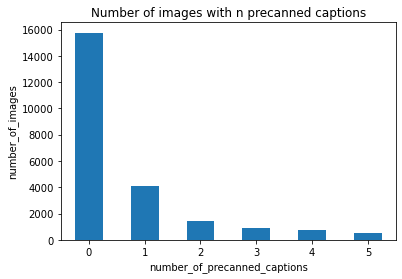

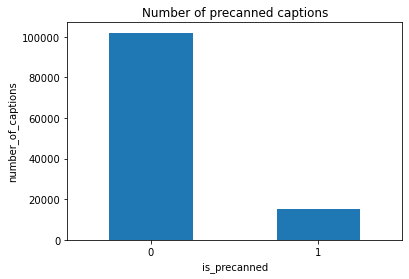

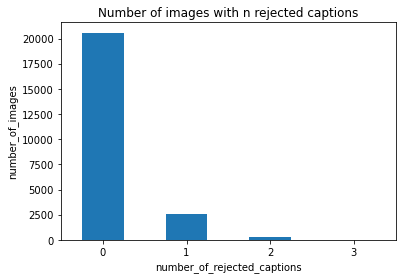

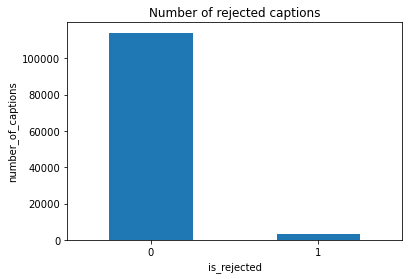

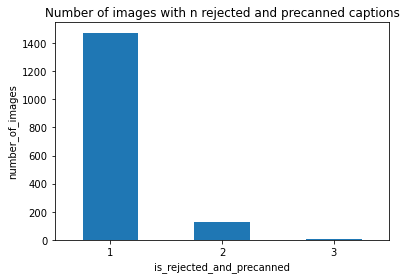

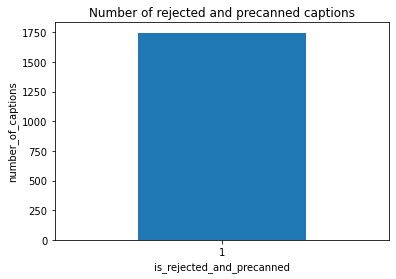

In [3]:
prepare('train')

       number_of_images  number_of_precanned_captions
Index                                                
0                  5222                             0
1                  1297                             1
2                   480                             2
3                   286                             3
4                   273                             4
5                   192                             5
       number_of_captions  is_precanned
Index                                  
0                   33583             0
1                    5167             1
       number_of_images  number_of_rejected_captions
Index                                               
0                  6879                            0
1                   784                            1
2                    81                            2
3                     6                            3
       number_of_captions  is_rejected
Index                                 
0           

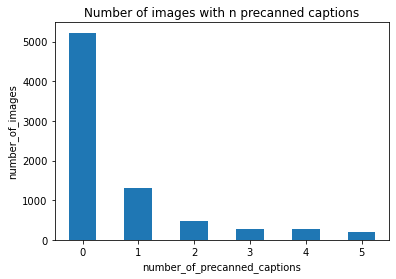

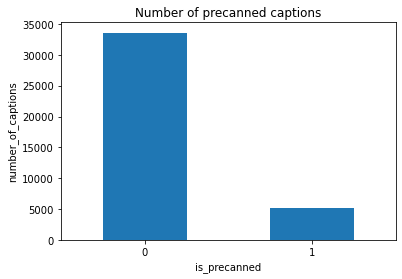

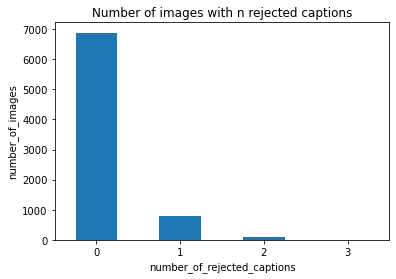

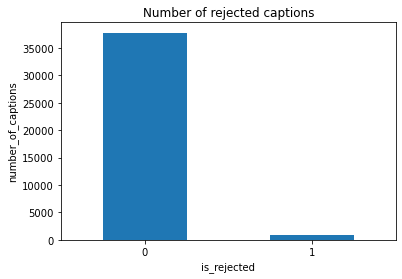

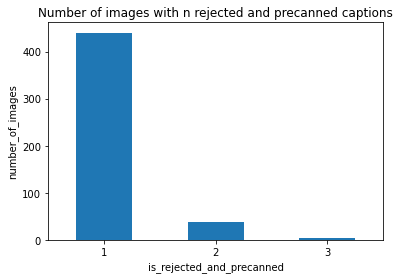

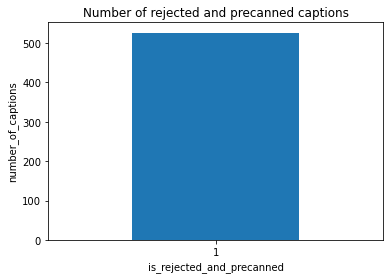

In [2]:
prepare('val')